In [1]:
using DifferentialEquations
using Plots; gr()
include("src/Utils.jl")
using Optim;

# Repressilator

$$
\frac{d}{dt}{p_i} = \alpha\left(\epsilon + (1 - \epsilon)\frac{1}{1 + p_{i - 1}^n}\right) - p_i
$$

Where $i = 1, 2, 3$. The index wraps around so that $1 - 1$ gives 3. A similar model is described in Elowitz and Stanislas 2000. Here I "lumped together" transcription and translation, unlike in Elowitz's paper where the two steps have individual equations.
The unit of time is $1/\beta$ and the unit concentration is $K_M$.

A sufficient condition for the equilibrium $(p_*, p_*, p_*)$ to be stable is

$$
\alpha(1 - \epsilon)n\frac{p_*^{n - 1}}{(1 + p_*^n)^2} - 2 < 0
$$

Where $p_*$ satisfies

$$
\alpha\left(\epsilon + (1 - \epsilon)\frac{\alpha}{1 + p_*^n}\right) - p_* = 0
$$

## IVP

In [2]:
function repressilator!(dX, X, p, t)
    p1, p2, p3 = X
    ϵ, a, n = p
    
    dX[1] = a*(ϵ + (1 - ϵ)/(1 + p3^n)) - p1
    dX[2] = a*(ϵ + (1 - ϵ)/(1 + p1^n)) - p2
    dX[3] = a*(ϵ + (1 - ϵ)/(1 + p2^n)) - p3
    
    nothing
end;

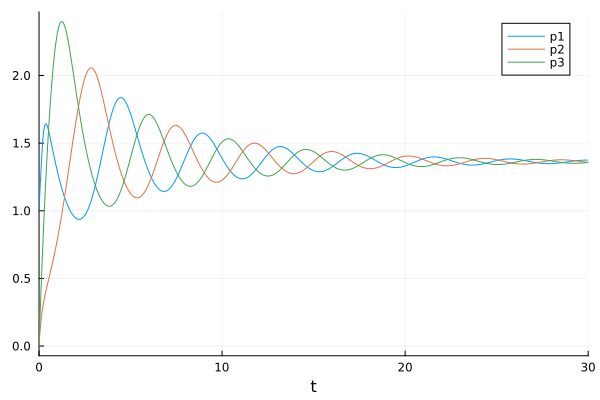

In [3]:
ϵ = 0.15
a = 4
n = 4

p0 = [1, 0, 0]
tspan = (0, 30)

prob = ODEProblem(repressilator!, p0, tspan, [ϵ, a, n])
sol = solve(prob, abstol=1e-8, reltol=1e-8)

plot(sol, labels=reshape(["p1", "p2", "p3"], 1, :))

## Find equilibrium

In [4]:
symmetric_rhs(p, ϵ, a, n) = a*(ϵ + (1 - ϵ)/(1 + p^n)) - p

ϵ = 0
a = 4
n = 4

p0 = [1.0]

res = optimize(x -> symmetric_rhs(first(x), ϵ, a, n)^2, p0, LBFGS(); autodiff=:forward)

 * Status: success

 * Candidate solution
    Final objective value:     1.087113e-23

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 6.09e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.96e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.27e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.85e+13 ≰ 0.0e+00
    |g(x)|                 = 2.49e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    15
    ∇f(x) calls:   15


In [5]:
# Hopf evaluation: stable if negative
hopf_ev(pss, ϵ, a, n) = a*(1 - ϵ)*n*pss^(n - 1) -2*(1 + pss^n)^2

hopf_ev (generic function with 1 method)

## Find Hopf points

In [6]:
a = 4
n = 4

function hopf_ev_from_para(_ϵ, _a, _n)
    #p0 = [10.0]
    res = optimize(x -> symmetric_rhs(x, _ϵ, _a, _n)^2, 0.0, 20.0)
    pss = first(Optim.minimizer(res))
    return hopf_ev(pss, _ϵ, _a, _n)
end

res = optimize(x -> hopf_ev_from_para(x, a, n)^2, 0.0, 1.0)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 1.000000]
 * Minimizer: 1.110946e-01
 * Minimum: 1.004174e-16
 * Iterations: 19
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 20

In [7]:
hopf_ev_from_para(0.1, 4, 4)

1.1902024812955325

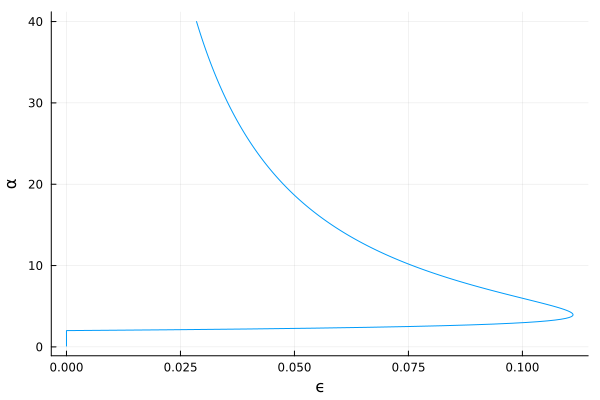

In [8]:
a_vec = 0.1:0.1:40
hopf_ϵ_vec = zeros(length(a_vec))
n = 4

for (i, a) in enumerate(a_vec)
    res = optimize(x -> hopf_ev_from_para(x, a, n)^2, 0.0, 1.0)
    hopf_ϵ_vec[i] = Optim.minimizer(res)
end

plot(hopf_ϵ_vec, a_vec, legend=false)
xlabel!("ϵ")
ylabel!("α")

## Numerically find the period

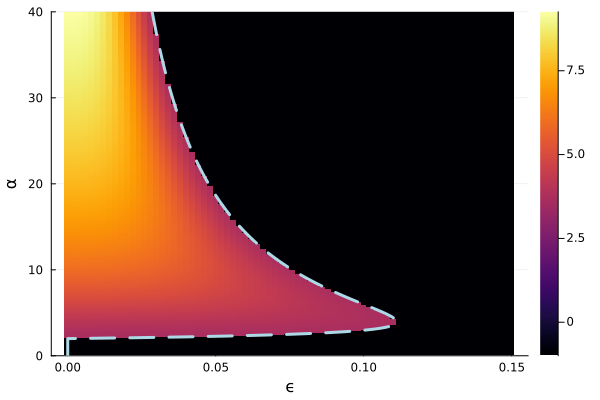

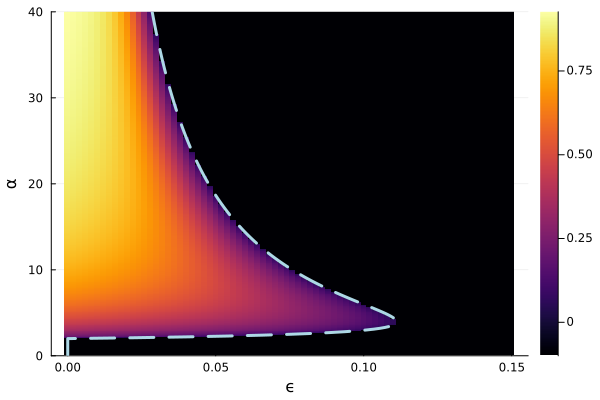

In [18]:
ϵ_vec = 0.0:2e-3:0.15
a_vec = 0.1:0.1:40
n = 4

# find period numerically
per_mat = zeros(length(ϵ_vec), length(a_vec))
amp_mat = zeros(length(ϵ_vec), length(a_vec))
    
p0 = [1, 0, 0]

for (i, ϵ) in enumerate(ϵ_vec)
    for (j, a) in enumerate(a_vec)
        converge, amplitude, per, phase = 
        attracted_to(repressilator!, p0, 50, [ϵ, a, n], burnin=25, conv_tol=5e-3, amp_cutoff=5e-2)
        per_mat[i, j] = per
        amp_mat[i, j] = amplitude == -1 ? -0.1 : amplitude
    end
end

# find hopf points from closed forms
hopf_ϵ_vec = zeros(length(a_vec))

for (i, a) in enumerate(a_vec)
    res = optimize(x -> hopf_ev_from_para(x, a, n)^2, 0.0, 1.0)
    hopf_ϵ_vec[i] = Optim.minimizer(res)
end
       
p = heatmap(ϵ_vec, a_vec, transpose(per_mat))
plot!(p, hopf_ϵ_vec, a_vec; legend=false, linestyle=:dash, color=:lightblue, linewidth=3)
xlabel!(p, "ϵ")
ylabel!(p, "α")
ylims!(p, 0, 40)
display(p)

heatmap(ϵ_vec, a_vec, transpose(amp_mat))
plot!(hopf_ϵ_vec, a_vec; legend=false, linestyle=:dash, color=:lightblue, linewidth=3)
xlabel!("ϵ")
ylabel!("α")
ylims!(0, 40)

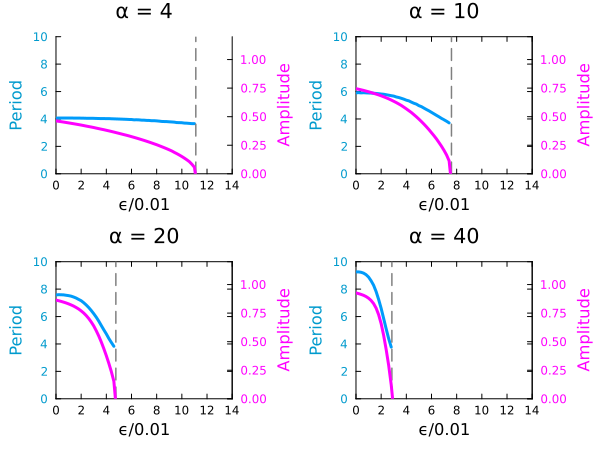

In [19]:
# intersect at fixed alpha
fixed_a_vec = [4.0, 10.0, 20.0, 40.0]

fil_id = []
j = 1
for (i, a) in enumerate(a_vec)
    if abs(fixed_a_vec[j] - a) < 1e-6
        fil_id = [fil_id..., i]
        j += 1
        if j > length(fixed_a_vec)
            break
        end
    end
end

fil_per_mat = per_mat[:, fil_id]
fil_per_mat = (x -> x == -1 ? NaN : x).(fil_per_mat)

fil_amp_mat = amp_mat[:, fil_id]
fil_amp_mat = (x -> x == -1 ? NaN : x).(fil_amp_mat)

# plot
p = plot(ϵ_vec*100, fil_per_mat; layout=4, legend=false, 
    title=(x -> "α = $(Int(x))").(transpose(fixed_a_vec)), size=(600, 450), linewidth=3,
    framestyle=:box, grid=false, framewidth=2, margin=2Plots.mm, 
    yguidefontcolor="deepskyblue3", ytickfontcolor="deepskyblue3")
ylims!(p, 0, 10)
xlims!(0, 14)
xlabel!(p, "ϵ/0.01")
ylabel!(p, "Period")

for i in 1:4
    plot!(twinx(p[i]), ϵ_vec*100, fil_amp_mat[:, i]; legend=false, 
    linewidth=3, color="magenta", ylims=(0, 1.2), xlims=(0, 14), 
    tickfontcolor="magenta", yguidefontcolor="magenta", ylabel="Amplitude")
    # hopf point
    vline!(p[i], [hopf_ϵ_vec[fil_id[i]]]*100, linestyle=:dash, color=:gray, linewidth=1.5)
end

display(p)

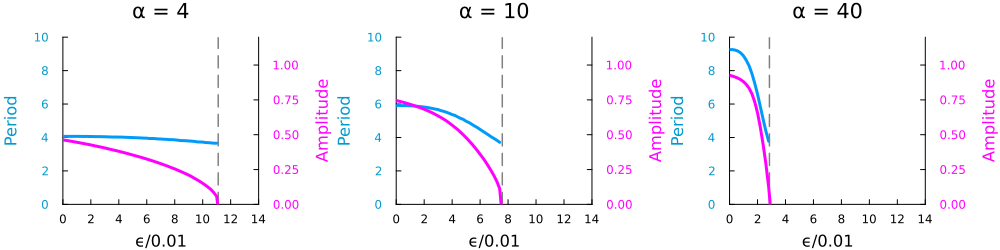

In [33]:
# intersect at fixed alpha
fixed_a_vec = [4.0, 10.0, 40.0]

fil_id = []
j = 1
for (i, a) in enumerate(a_vec)
    if abs(fixed_a_vec[j] - a) < 1e-6
        fil_id = [fil_id..., i]
        j += 1
        if j > length(fixed_a_vec)
            break
        end
    end
end

fil_per_mat = per_mat[:, fil_id]
fil_per_mat = (x -> x == -1 ? NaN : x).(fil_per_mat)

fil_amp_mat = amp_mat[:, fil_id]
fil_amp_mat = (x -> x == -1 ? NaN : x).(fil_amp_mat)

# plot
p = plot(ϵ_vec*100, fil_per_mat[:, 1:3]; layout=(1, 3), legend=false, 
    title=(x -> "α = $(Int(x))").(transpose(fixed_a_vec)), size=(1000, 250), linewidth=3,
    grid=false, framewidth=2, margin=5Plots.mm, 
    yguidefontcolor="deepskyblue3", ytickfontcolor="deepskyblue3")
ylims!(p, 0, 10)
xlims!(0, 14)
xlabel!(p, "ϵ/0.01")
ylabel!(p, "Period")

for i in 1:3
    plot!(twinx(p[i]), ϵ_vec*100, fil_amp_mat[:, i]; legend=false, 
    linewidth=3, color="magenta", ylims=(0, 1.2), xlims=(0, 14),
    tickfontcolor="magenta", yguidefontcolor="magenta", ylabel="Amplitude")
    # hopf point
    vline!(p[i], [hopf_ϵ_vec[fil_id[i]]]*100, linestyle=:dash, color=:gray, linewidth=1.5)
end

display(p)

In [34]:
# savefig(p, "outputs/repressilator_per_amp_sensitivity_to_leakiness.png")

"/home/randolph/Rust_lab/kaiabc/outputs/repressilator_per_amp_sensitivity_to_leakiness.png"

### Try a different $n$

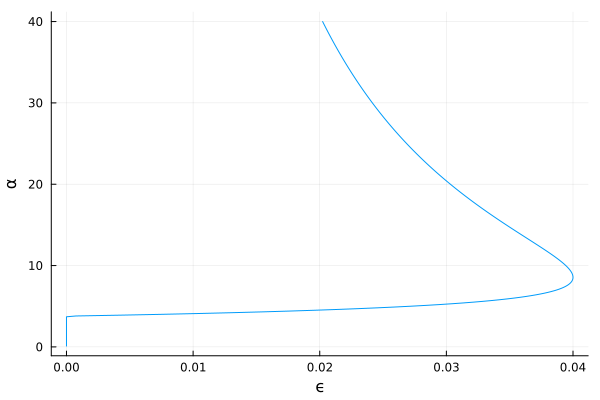

In [11]:
a_vec = 0.1:0.1:40
hopf_ϵ_vec = zeros(length(a_vec))
n = 3

for (i, a) in enumerate(a_vec)
    res = optimize(x -> hopf_ev_from_para(x, a, n)^2, 0.0, 1.0)
    hopf_ϵ_vec[i] = Optim.minimizer(res)
end

plot(hopf_ϵ_vec, a_vec, legend=false)
xlabel!("ϵ")
ylabel!("α")

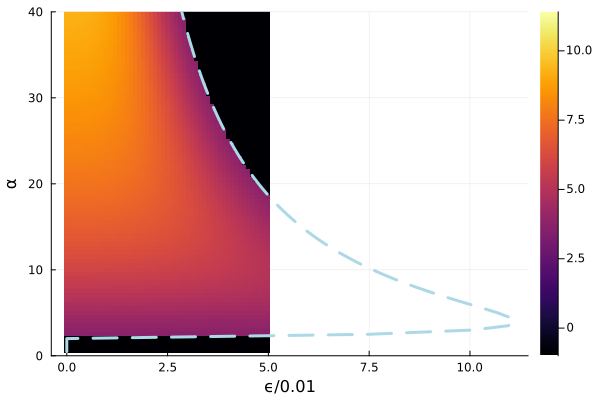

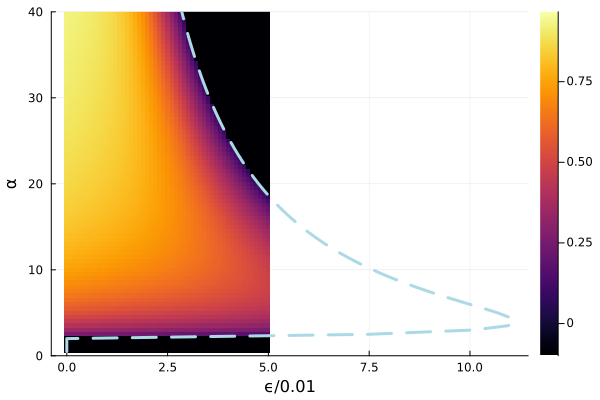

In [37]:
ϵ_vec = 0.0:1e-3:0.05
a_vec = 0.5:0.5:100
n = 4

# find period numerically
per_mat = zeros(length(ϵ_vec), length(a_vec))
amp_mat = zeros(length(ϵ_vec), length(a_vec))
    
p0 = [1, 0, 0]

for (i, ϵ) in enumerate(ϵ_vec)
    for (j, a) in enumerate(a_vec)
        converge, amplitude, per, phase = 
        attracted_to(repressilator!, p0, 50, [ϵ, a, n], burnin=25, conv_tol=5e-3, amp_cutoff=5e-2)
        per_mat[i, j] = per
        amp_mat[i, j] = amplitude == -1 ? -0.1 : amplitude
    end
end

# find hopf points from closed forms
hopf_ϵ_vec = zeros(length(a_vec))

for (i, a) in enumerate(a_vec)
    res = optimize(x -> hopf_ev_from_para(x, a, n)^2, 0.0, 1.0)
    hopf_ϵ_vec[i] = Optim.minimizer(res)
end
       
p = heatmap(100ϵ_vec, a_vec, transpose(per_mat))
plot!(p, 100hopf_ϵ_vec, a_vec; legend=false, linestyle=:dash, color=:lightblue, linewidth=3)
xlabel!(p, "ϵ/0.01")
ylabel!(p, "α")
ylims!(p, 0, 40)
display(p)

heatmap(100ϵ_vec, a_vec, transpose(amp_mat))
plot!(100hopf_ϵ_vec, a_vec; legend=false, linestyle=:dash, color=:lightblue, linewidth=3)
xlabel!("ϵ/0.01")
ylabel!("α")
ylims!(0, 40)

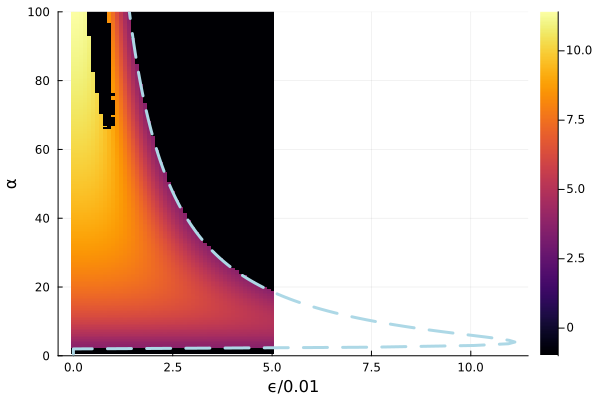

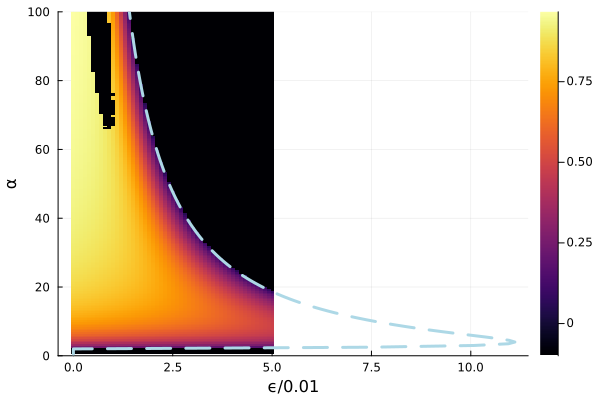

In [39]:
p = heatmap(100ϵ_vec, a_vec, transpose(per_mat))
plot!(p, 100hopf_ϵ_vec, a_vec; legend=false, linestyle=:dash, color=:lightblue, linewidth=3)
xlabel!(p, "ϵ/0.01")
ylabel!(p, "α")
ylims!(p, 0, 100)
display(p)

heatmap(100ϵ_vec, a_vec, transpose(amp_mat))
plot!(100hopf_ϵ_vec, a_vec; legend=false, linestyle=:dash, color=:lightblue, linewidth=3)
xlabel!("ϵ/0.01")
ylabel!("α")
ylims!(0, 100)

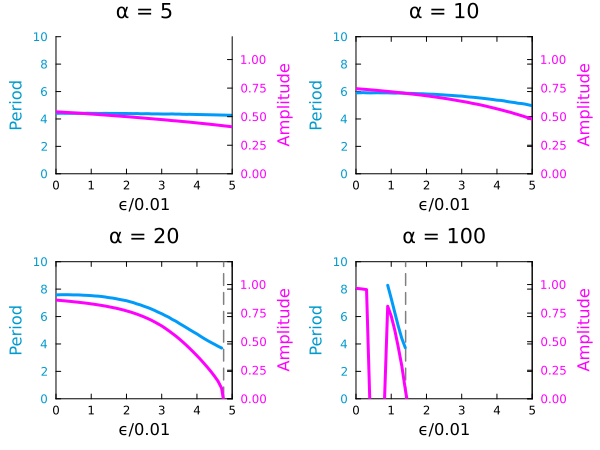

In [40]:
# intersect at fixed alpha
fixed_a_vec = [5.0, 10.0, 20.0, 100.0]

fil_id = []
j = 1
for (i, a) in enumerate(a_vec)
    if abs(fixed_a_vec[j] - a) < 1e-6
        fil_id = [fil_id..., i]
        j += 1
        if j > length(fixed_a_vec)
            break
        end
    end
end

fil_per_mat = per_mat[:, fil_id]
fil_per_mat = (x -> x == -1 ? NaN : x).(fil_per_mat)

fil_amp_mat = amp_mat[:, fil_id]
fil_amp_mat = (x -> x == -1 ? NaN : x).(fil_amp_mat)

# plot
p = plot(ϵ_vec*100, fil_per_mat; layout=4, legend=false, 
    title=(x -> "α = $(Int(x))").(transpose(fixed_a_vec)), size=(600, 450), linewidth=3,
    framestyle=:box, grid=false, framewidth=2, margin=2Plots.mm, 
    yguidefontcolor="deepskyblue3", ytickfontcolor="deepskyblue3")
ylims!(p, 0, 10)
xlims!(0, 5)
xlabel!(p, "ϵ/0.01")
ylabel!(p, "Period")

for i in 1:4
    plot!(twinx(p[i]), ϵ_vec*100, fil_amp_mat[:, i]; legend=false, 
    linewidth=3, color="magenta", ylims=(0, 1.2), xlims=(0, 5), 
    tickfontcolor="magenta", yguidefontcolor="magenta", ylabel="Amplitude")
    # hopf point
    vline!(p[i], [hopf_ϵ_vec[fil_id[i]]]*100, linestyle=:dash, color=:gray, linewidth=1.5)
end

display(p)